# Проект №3. О вкусной и здоровой пище 

Калашников С.Д.

Датасет состоит из десяти столбцов, содержащих следующую информацию:

Restaurant_id — идентификационный номер ресторана / сети ресторанов;   
City — город, в котором находится ресторан;  
Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;  
Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;  
Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);  
Price Range — диапазон цен в ресторане;  
Number of Reviews — количество отзывов о ресторане;  
Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;  
URL_TA — URL страницы ресторана на TripAdvisor;  
ID_TA — идентификатор ресторана в базе данных TripAdvisor.  



## Библиотеки

In [161]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings
import re
import datetime
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 50)  # отображаем больше строк
pd.set_option('display.max_columns', 50)  # отображаем больше столбцов
plt.style.use('seaborn')  # выбор стиля графиков

%matplotlib inline

for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input\sf-dst-restaurant-rating\kaggle_task.csv
kaggle/input\sf-dst-restaurant-rating\main_task.csv
kaggle/input\sf-dst-restaurant-rating\sample_submission.csv


# Функции

In [162]:
def med_iqr(series, verbose=True):
    # Функция возвращает медиану, Q1, Q3, IQR
    median = series.median()
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)
    IQR = perc75 - perc25

    if verbose:
        print('25-й перцентиль: {},'.format(perc25),
              '75-й перцентиль: {},'.format(perc75),
              "IQR: {}, ".format(IQR),
              "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

    temp_dict = {'median': median, 'perc25': perc25,
                 'perc75': perc75, 'iqr': IQR}

    return temp_dict


def review_extraction(row):
    # Функция вызывается для разделения столбца отзывы
    cell = row['reviews']

    # создаём вспомогательный список для сохранения временных данных
    aux_list = [[], []]
    if type(cell) == str and lrx.fullmatch(cell):  # сравнить с шаблоном поиска
        aux_list = eval(cell)  # преобразовать в список

    row['first_review'] = aux_list[0][1] if len(aux_list[0]) > 1 else nan
    row['last_review'] = aux_list[0][0] if len(aux_list[0]) > 0 else nan

    row['first_date'] = pd.to_datetime(
        aux_list[1][1] if len(aux_list[1]) > 1 else nan)
    row['last_date'] = pd.to_datetime(aux_list[1][0] if len(
        aux_list[1]) > 0 else nan, format='%m/%d/%Y', errors='coerce')

    row['first_date'] = pd.to_datetime(row['first_date'])
    row['last_date'] = pd.to_datetime(row['last_date'])

    return row


def get_days(timedelta):
    # Функция преобразования дат в дени'
    return timedelta.days


def get_cuisine_rare(row):
    # Функция создания редкие кухонь
    number = 0
    for i in cuisine_rare_lst:
        if i in row:
            number += 1  # подсчёт кол-во редких кухонь
    return number


def get_local_cuisine(row):
    # Функция для идентификации местной кухни
    local_cuis = cuisine_region[row['country']]
    for i in local_cuis:
        if i in row['cuisine_style'] and i != '':
            return 1
    return 0


def get_vegan(row):
    # функция определения "вегано" подобной еды
    vegan_cuis = ['Vegetarian Friendly', 'Vegan Options',  # All vegan food in my oppinion
                  'Gluten Free Options', 'Healthy', ]
    for i in vegan_cuis:
        if i in row['cuisine_style'] and i != '':
            return 1
    return 0


def round_rating_pred(rating_pred):
    # Функция для округления прогнозируемых оценок
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

Зафиксируем версию пакетов, RANDOM_SEED и установи текущую дату, чтобы эксперименты были воспроизводимы

In [163]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('19/04/2021')

# 1. Загрузка и первичный осмотр датасета

In [164]:
DATA_DIR = 'kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [165]:
display(df_train.sample(2))
df_train.info()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
26720,id_4434,Rome,NaN,4435.0,4.5,NaN,12.0,"[[], []]",/Restaurant_Review-g187791-d8117867-Reviews-Ch...,d8117867
24120,id_0,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [166]:
display(df_test.sample(2))
df_test.info()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
235,id_235,Prague,['Italian'],1662.0,$$ - $$$,4.0,"[['Lovely place - I fell in love :)', 'Addicti...",/Restaurant_Review-g274707-d11948178-Reviews-V...,d11948178
5979,id_5979,Milan,"['American', 'Bar', 'Fast Food', 'Barbecue']",914.0,$,485.0,"[['Good burger', 'excellent burger, not cheap'...",/Restaurant_Review-g187849-d4939155-Reviews-Bu...,d4939155


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [167]:
display(sample_submission.sample(2))
sample_submission.info()

,Restaurant_id,Rating
1959,id_1959,2.0
2219,id_2219,2.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


Для правильной обработки объединим обучающий и тестовый наборы в один набор данных  
Мы должны прогнозировать "рейтинг", в тестовом наборе мы заполняем его 0

In [168]:
df_train['sample'] = 1  # обучающий
df_test['sample'] = 0  # тестовый
df_test['Rating'] = 0  # значения Rating, заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем

In [169]:
display(df.sample(3))
df.info()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
34602,id_4413,Paris,"['Argentinean', 'South American']",4414.0,$$ - $$$,88.0,"[['Unusual', 'Something different in Paris 17'...",/Restaurant_Review-g187147-d897223-Reviews-Le_...,d897223,1,4.0
26182,id_4369,Barcelona,"['Seafood', 'Mediterranean', 'European', 'Span...",4370.0,$$ - $$$,219.0,"[['Lovely position, good food, friendly and f....",/Restaurant_Review-g187497-d986285-Reviews-La_...,d986285,1,3.5
16620,id_277,Lisbon,"['Mediterranean', 'European', 'Portuguese', 'V...",278.0,$$ - $$$,323.0,"[['Authentic with a contemporary touch', 'Best...",/Restaurant_Review-g189158-d2399630-Reviews-Pe...,d2399630,1,4.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


### Определяем какие типы данных хранятся в каждой ячейке-столбце

In [170]:
for i, j in enumerate(df.columns):
    print(j, type(df.loc[1][i]))

Restaurant_id <class 'str'>
City <class 'str'>
Cuisine Style <class 'str'>
Ranking <class 'numpy.float64'>
Price Range <class 'str'>
Number of Reviews <class 'numpy.float64'>
Reviews <class 'str'>
URL_TA <class 'str'>
ID_TA <class 'str'>
sample <class 'numpy.int64'>
Rating <class 'numpy.float64'>


### Анализ всех столбцов на уникальные и NaN значения в числовом и процентном соотношении.

In [171]:
for c in df.columns:
    print("\n--------- %s --------\n" % c)
    print('Уникальные значения в %s =' % c, df[c].dropna().unique())
    print()
    print('Количество уникальных значений в %s =' %
          c, len(df[c].value_counts().sort_index()))
    print()
    print('Количество пустых значений в %s =' % c, df[c].isnull().sum(axis=0))
    print()
    print('Процент пустых значений в %s = ' %
          c, round((np.mean(df[c].isnull()))*100), '%')


--------- Restaurant_id --------

Уникальные значения в Restaurant_id = ['id_0' 'id_1' 'id_2' ... 'id_15736' 'id_12774' 'id_11658']

Количество уникальных значений в Restaurant_id = 13094

Количество пустых значений в Restaurant_id = 0

Процент пустых значений в Restaurant_id =  0 %

--------- City --------

Уникальные значения в City = ['Paris' 'Helsinki' 'Edinburgh' 'London' 'Bratislava' 'Lisbon' 'Budapest'
 'Stockholm' 'Rome' 'Milan' 'Munich' 'Hamburg' 'Prague' 'Vienna' 'Dublin'
 'Barcelona' 'Brussels' 'Madrid' 'Oslo' 'Amsterdam' 'Berlin' 'Lyon'
 'Athens' 'Warsaw' 'Oporto' 'Krakow' 'Copenhagen' 'Luxembourg' 'Zurich'
 'Geneva' 'Ljubljana']

Количество уникальных значений в City = 31

Количество пустых значений в City = 0

Процент пустых значений в City =  0 %

--------- Cuisine Style --------

Уникальные значения в Cuisine Style = ["['Bar', 'Pub']"
 "['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"
 "['Vegetarian Friendly']" ...
 "['Steakh

### Переименование столбцов.

In [172]:
df.rename(columns={'Restaurant_id': 'restaurant_id',
                   'City': 'city',
                   'Cuisine Style': 'cuisine_style',
                   'Ranking': 'ranking',
                   'Rating': 'rating',
                   'Price Range': 'price_range',
                   'Number of Reviews': 'reviews_number',
                   'Reviews': 'reviews',
                   'URL_TA': 'url_ta',
                   'ID_TA': 'id_ta'}, inplace=True)
df.head(1)

,restaurant_id,city,cuisine_style,ranking,price_range,reviews_number,reviews,url_ta,id_ta,sample,rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0


## Итог

Датафрейм имеет 50000 строк и 10 столбцов  
В столбце "cuisine_style" 23% пропущенных значений  
В столбце "price_range" 35% пропущенных значений  
В столбце "reviews_number" 6% пропущенных значений 
В столбце «reviews» нет ни одного пропущенного значения, но в тоже время имеется следующее значение: «[[], []]». Определенно это пропущенное значение, которое необходимо обработать при дальнейшей обработке данных.  

# 2. Первичный анализ и предобработка предоставленных данных:

### 2.1 Рейтинг

Text(0.5, 0, 'Рейтинг')

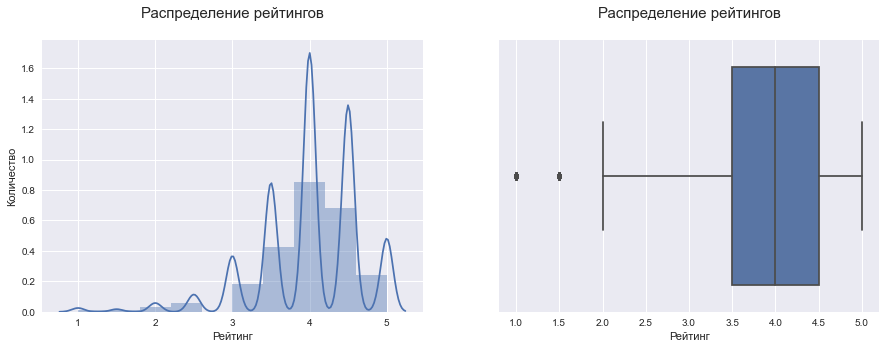

In [173]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(df_train.Rating.values, bins=10)
plt.title('Распределение рейтингов\n', fontsize=15)
plt.xlabel('Рейтинг')
plt.ylabel('Количество')

plt.subplot(122)
sns.boxplot(df_train.Rating.values)
plt.title('Распределение рейтингов\n', fontsize=15)
plt.xlabel('Рейтинг')

In [174]:
df_train['Rating'].describe()

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

Целевая переменная имеет нормальное распределение, смещенное вправо от 1 до 5.   
Первый и третий квартили находятся в диапазоне от 3,5 до 4,5, медиана - 4.   
Также наблюдались выбросы для целевой переменной.

### 2.2 Идентификационный номер ресторана

In [175]:
print(f'Уникальные значения: {df.restaurant_id.nunique()}')
df['restaurant_id'].value_counts()

Уникальные значения: 13094


id_436      19
id_871      19
id_633      19
id_227      19
id_430      18
            ..
id_7129      1
id_10639     1
id_6685      1
id_15923     1
id_14048     1
Name: restaurant_id, Length: 13094, dtype: int64

Общее количество строк составляет 50.000, количество уникальных идентификаторов - 13.094
Несколько ресторанов в наборе данных являются сетевыми, что подтверждается описанием датасета.

### 2.3 Город

Количество городов: 31


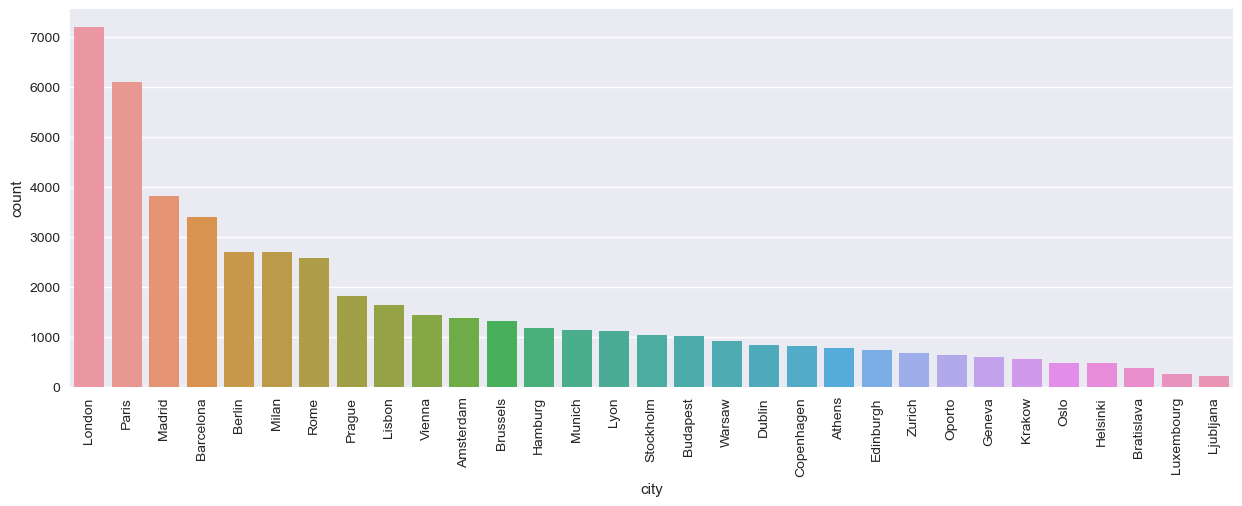

In [176]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df['city'], order=df['city'].value_counts().index)
plt.xticks(rotation=90)
print(f'Количество городов: {df.city.nunique()}')

Все города находятся в Европе.  
Большинство ресторанов расположены в Лондоне, Париже, Мадриде.

### 2.4 Кухня

Для набора статистики раскроем все представленные в датасете типы кухонь.   
Создадим отдельный список ресторанов у которых отсутвует значение.  
Пустые значения заполним переменной "unknown"

In [177]:
df['cuisine_style_empty'] = df['cuisine_style'].isnull().astype(
    'uint8')  # рестораны без кухонь
df['cuisine_style'] = df['cuisine_style'].fillna(
    "['unknown']")  # замена NaN на unknown
df['cuisine_style'] = df['cuisine_style'].apply(
    lambda x: eval(x))  # transform to a list

Создадим отдельный датафрейм для предворительного анализа

In [178]:
df1 = df[['city', 'cuisine_style', 'ranking', 'rating',
          'reviews_number']].explode('cuisine_style')
# (-1 для кухни "unknown")
print(f'Кол-во уникальных значений: {df1.cuisine_style.nunique()-1}')

Кол-во уникальных значений: 125


Топ 15 кухонь представленных в датасете

Text(0.5, 1.0, '15 самых популярных кухнь')

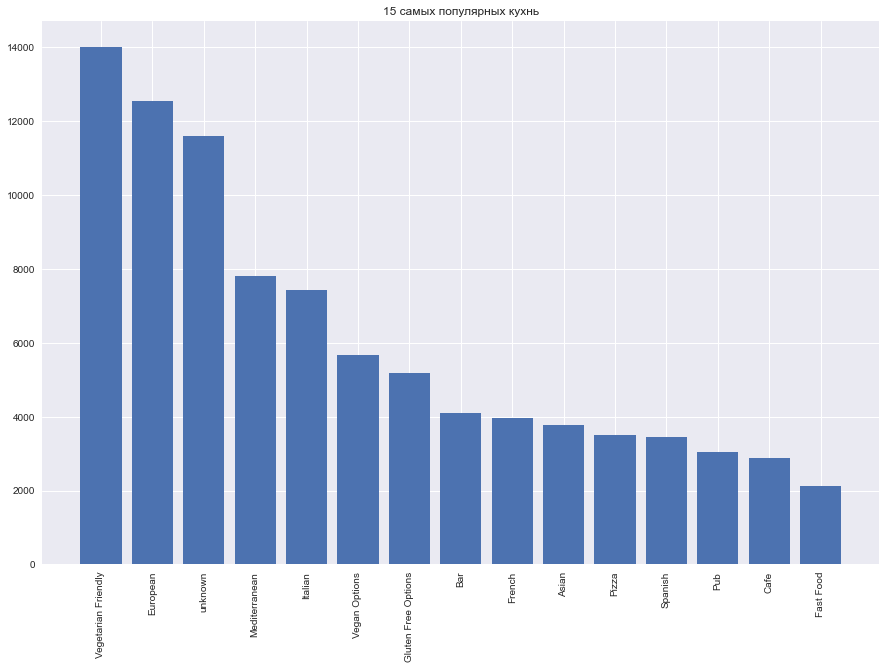

In [179]:
df_cuisine_style = df1['cuisine_style'].value_counts(
).sort_values(ascending=False)[:15]
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot()
plt.bar(x=df_cuisine_style.index, height=df_cuisine_style)
plt.xticks(rotation=90)
plt.title('15 самых популярных кухнь')

В наборе данных представлено 125 типов кухонь.
Одни из самых распространённых являются вегетарианская, веганская и безглютеновая, в дальнейшем эти значения можно объединить.

Оценим на какие  типы кухонь чаше всего оставляют отзывы.

Text(0.5, 1.0, '15 самых комментируемых кухонь')

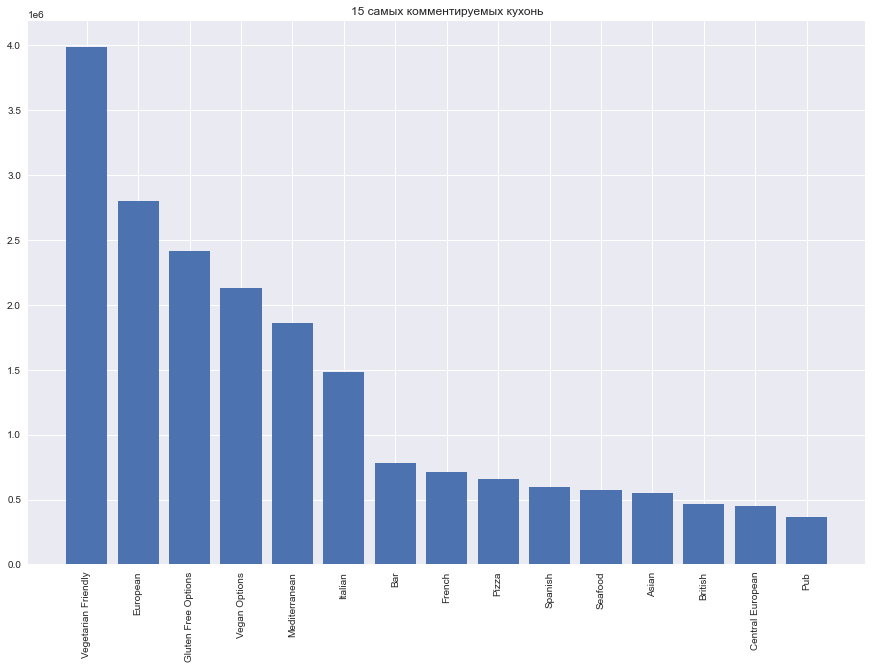

In [180]:
df_cuisine_style = df1.groupby(
    'cuisine_style').reviews_number.sum().sort_values(ascending=False)[:15]

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot()
plt.bar(x=df_cuisine_style.index, height=df_cuisine_style)
plt.xticks(rotation=90)
plt.title('15 самых комментируемых кухонь')

### 2.5 Ранг ресторана

Text(0.5, 0, 'Ранг')

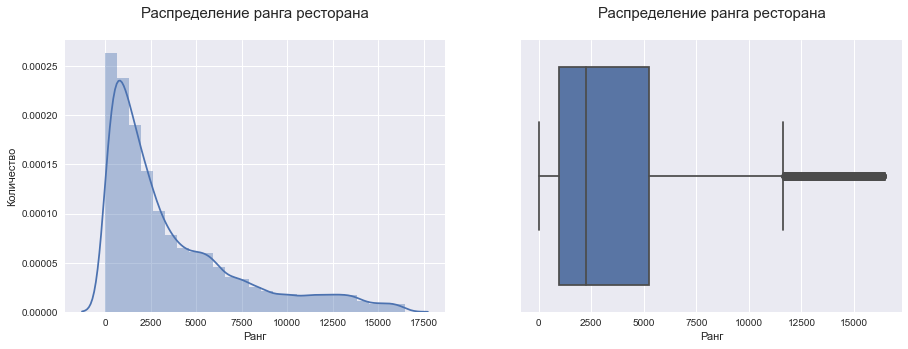

In [181]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(df.ranking.values, bins=25)
plt.title('Распределение ранга ресторана\n', fontsize=15)
plt.xlabel('Ранг')
plt.ylabel('Количество')

plt.subplot(122)
sns.boxplot(df.ranking.values)
plt.title('Распределение ранга ресторана\n', fontsize=15)
plt.xlabel('Ранг')

In [182]:
df['ranking'].describe()

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: ranking, dtype: float64

Из-за большого разброса значений а также сильного смешения, мы не можем оценивать, ранг без учёта города.  
Проведеём дополнительную оценку по каждому городу отдельно, для анализа возьмём 15 первых значений.

Text(0, 0.5, 'Количество')

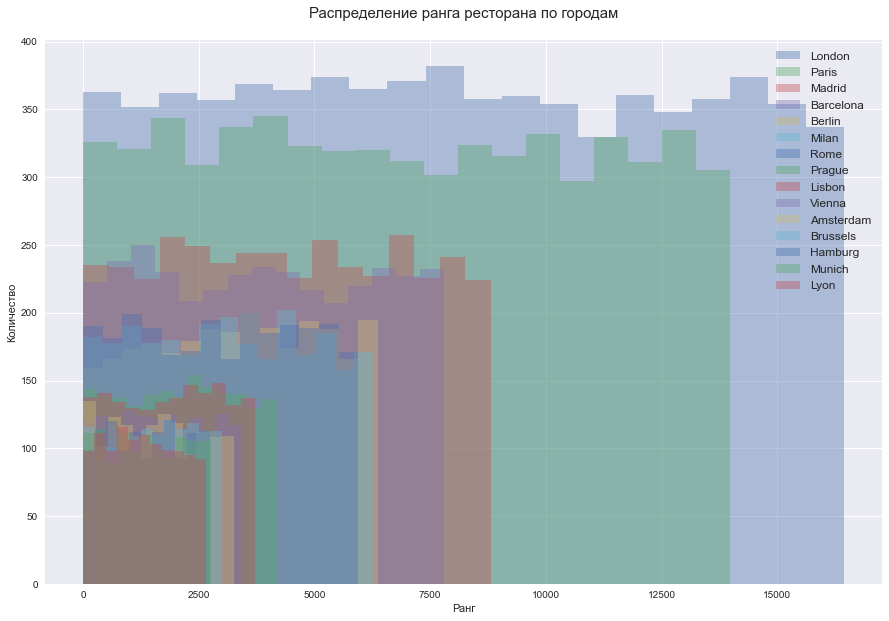

In [183]:
plt.figure(figsize=(15, 10))

for city in (df['city'].value_counts())[0:15].index:
    sns.distplot(df['ranking'][df['city'] == city], kde=False, label=city)

plt.legend(prop={'size': 12})
plt.title('Распределение ранга ресторана по городам\n', fontsize=15)
plt.xlabel('Ранг')
plt.ylabel('Количество')

Ранг ресторана имеет нормальное распределение в каждом отдельном городе, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.


### 2.6 Цены в ресторане

In [184]:
price_ranges = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df['price_range'] = df['price_range'].map(price_ranges)
df['price_range'] = df['price_range'].fillna(2)

Text(0, 0.5, 'Рейтинг')

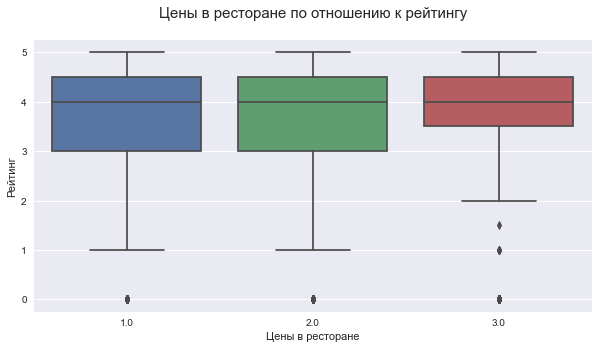

In [185]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='price_range', y='rating', data=df)

plt.title('Цены в ресторане по отношению к рейтингу\n', fontsize=15)
plt.xlabel('Цены в ресторане')
plt.ylabel('Рейтинг')

Рестораны с высокими ценами реже получают низкие оценки, чем рестораны со средним и дешевым уровнем.


Проверим влияние ценовой категории ресторана на количество отзывов

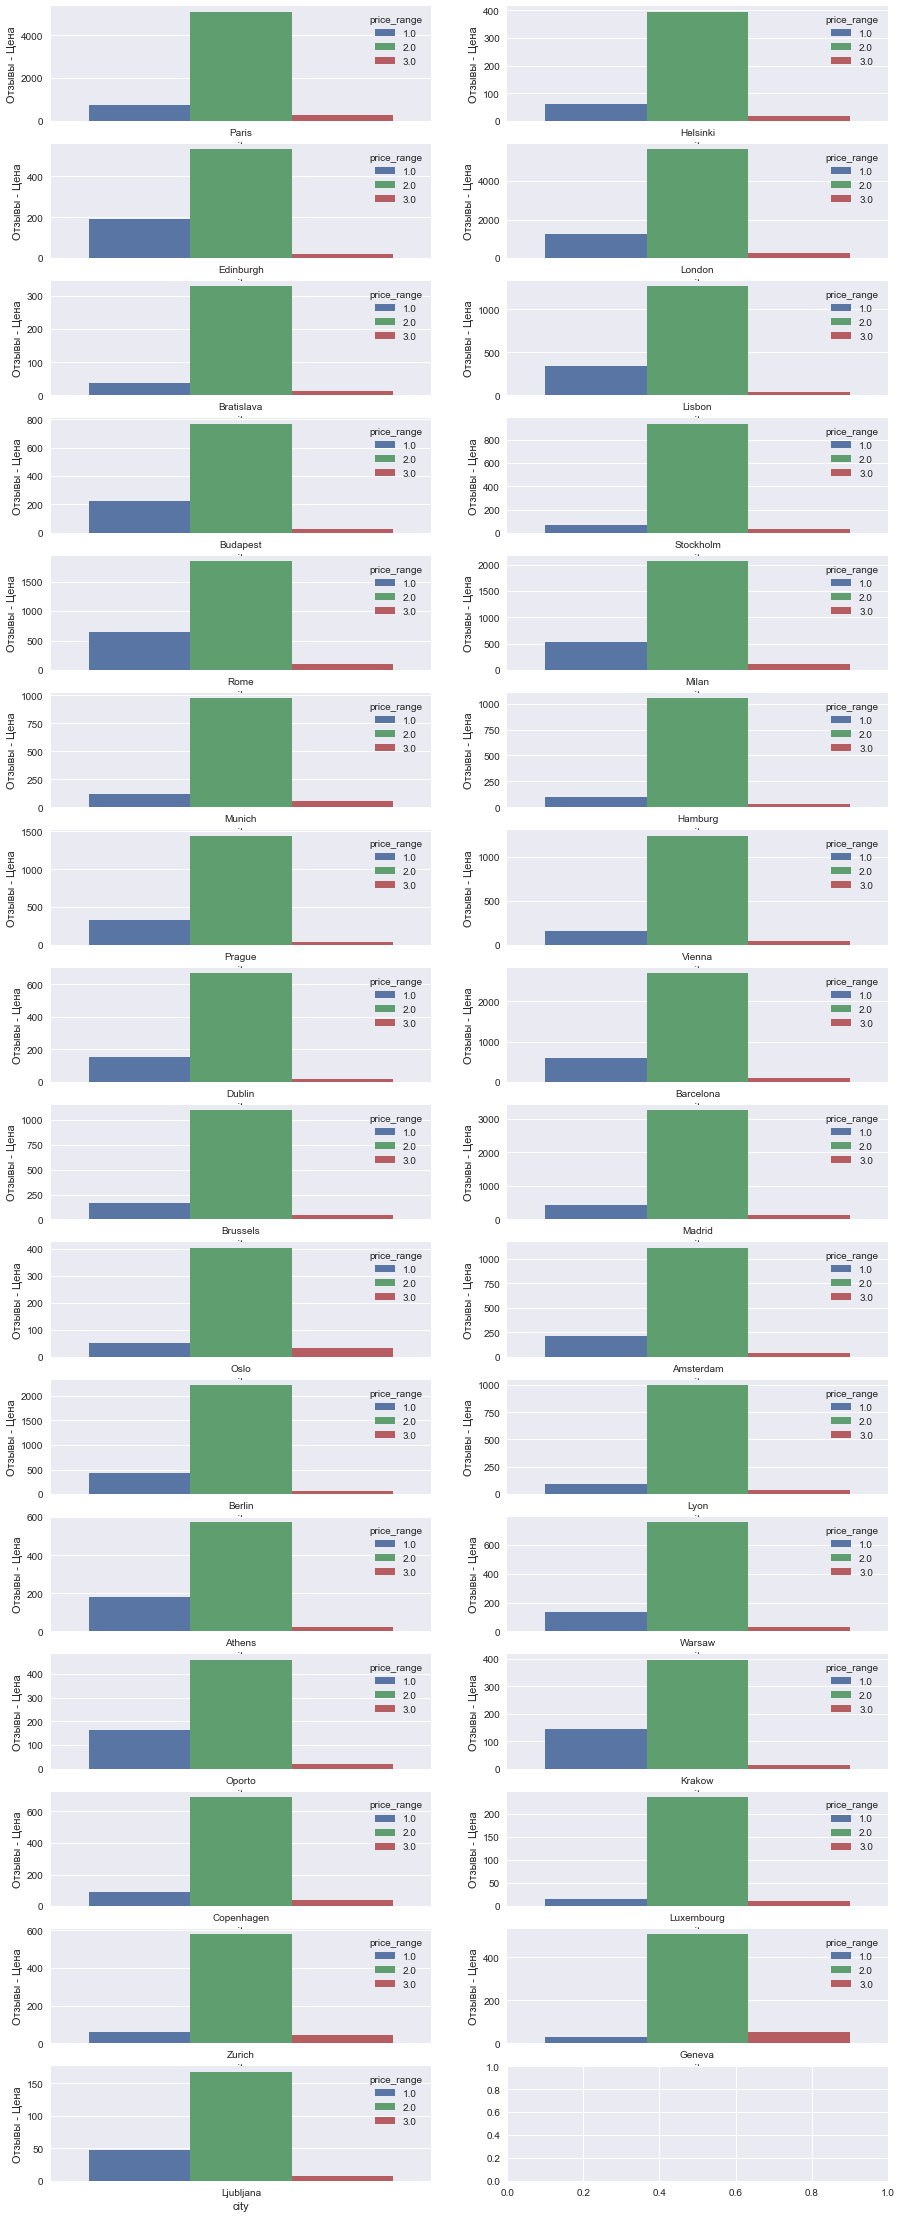

In [186]:
df_valid_rev = df[df['price_range'] != 'NotAvailable']
cities = df_valid_rev['city'].unique()

fig_price_ranges, ax_price_ranges = plt.subplots(16, 2, figsize=(15, 40))

ind = 1
for i in range(1, 17):
    for j in range(1, 3):
        if (ind <= len(cities)):
            city = cities[ind-1]
            ind += 1
            city_revs = df_valid_rev[df_valid_rev.city == city]
            df_revs = pd.DataFrame(city_revs.groupby(
                ['city', 'price_range']).restaurant_id.count())
            df_revs = df_revs.reset_index()
            fig_price_ranges.add_subplot(ax_price_ranges[i-1, j-1])
            sns.barplot(data=df_revs, x='city',
                        y='restaurant_id', hue='price_range')
            plt.ylabel('Отзывы - Цена')

Больше всего отзывов у ресторанов средней ценовой категории.

Посчитаем среднее количество отзывов для каждого ценового диапазона.
Для этого просуммируем отзывы по городам и ценовым категориям, затем получим количество ресторанов по городу и цене.

In [187]:
reviews_city_price = pd.DataFrame(df_valid_rev.groupby(
    ['city', 'price_range']).reviews_number.sum())  # сумма отзывов по городу
places_city_price = pd.DataFrame(df_valid_rev.groupby(
    ['city', 'price_range']).restaurant_id.count())  # кол-во ресторанов по городу
reviews_city_price['restaurants_number'] = places_city_price['restaurant_id']
reviews_city_price['avg_reviews'] = round(
    reviews_city_price.reviews_number / reviews_city_price.restaurants_number, 1)  # среднее количество отзывов по цене

In [188]:
reviews_city_price.head()

reviews_number  restaurants_number  avg_reviews
city      price_range                                                 
Amsterdam 1.0                 24898.0                 217        114.7
          2.0                148521.0                1114        133.3
          3.0                 20395.0                  41        497.4
Athens    1.0                 11264.0                 180         62.6
          2.0                 51009.0                 572         89.2

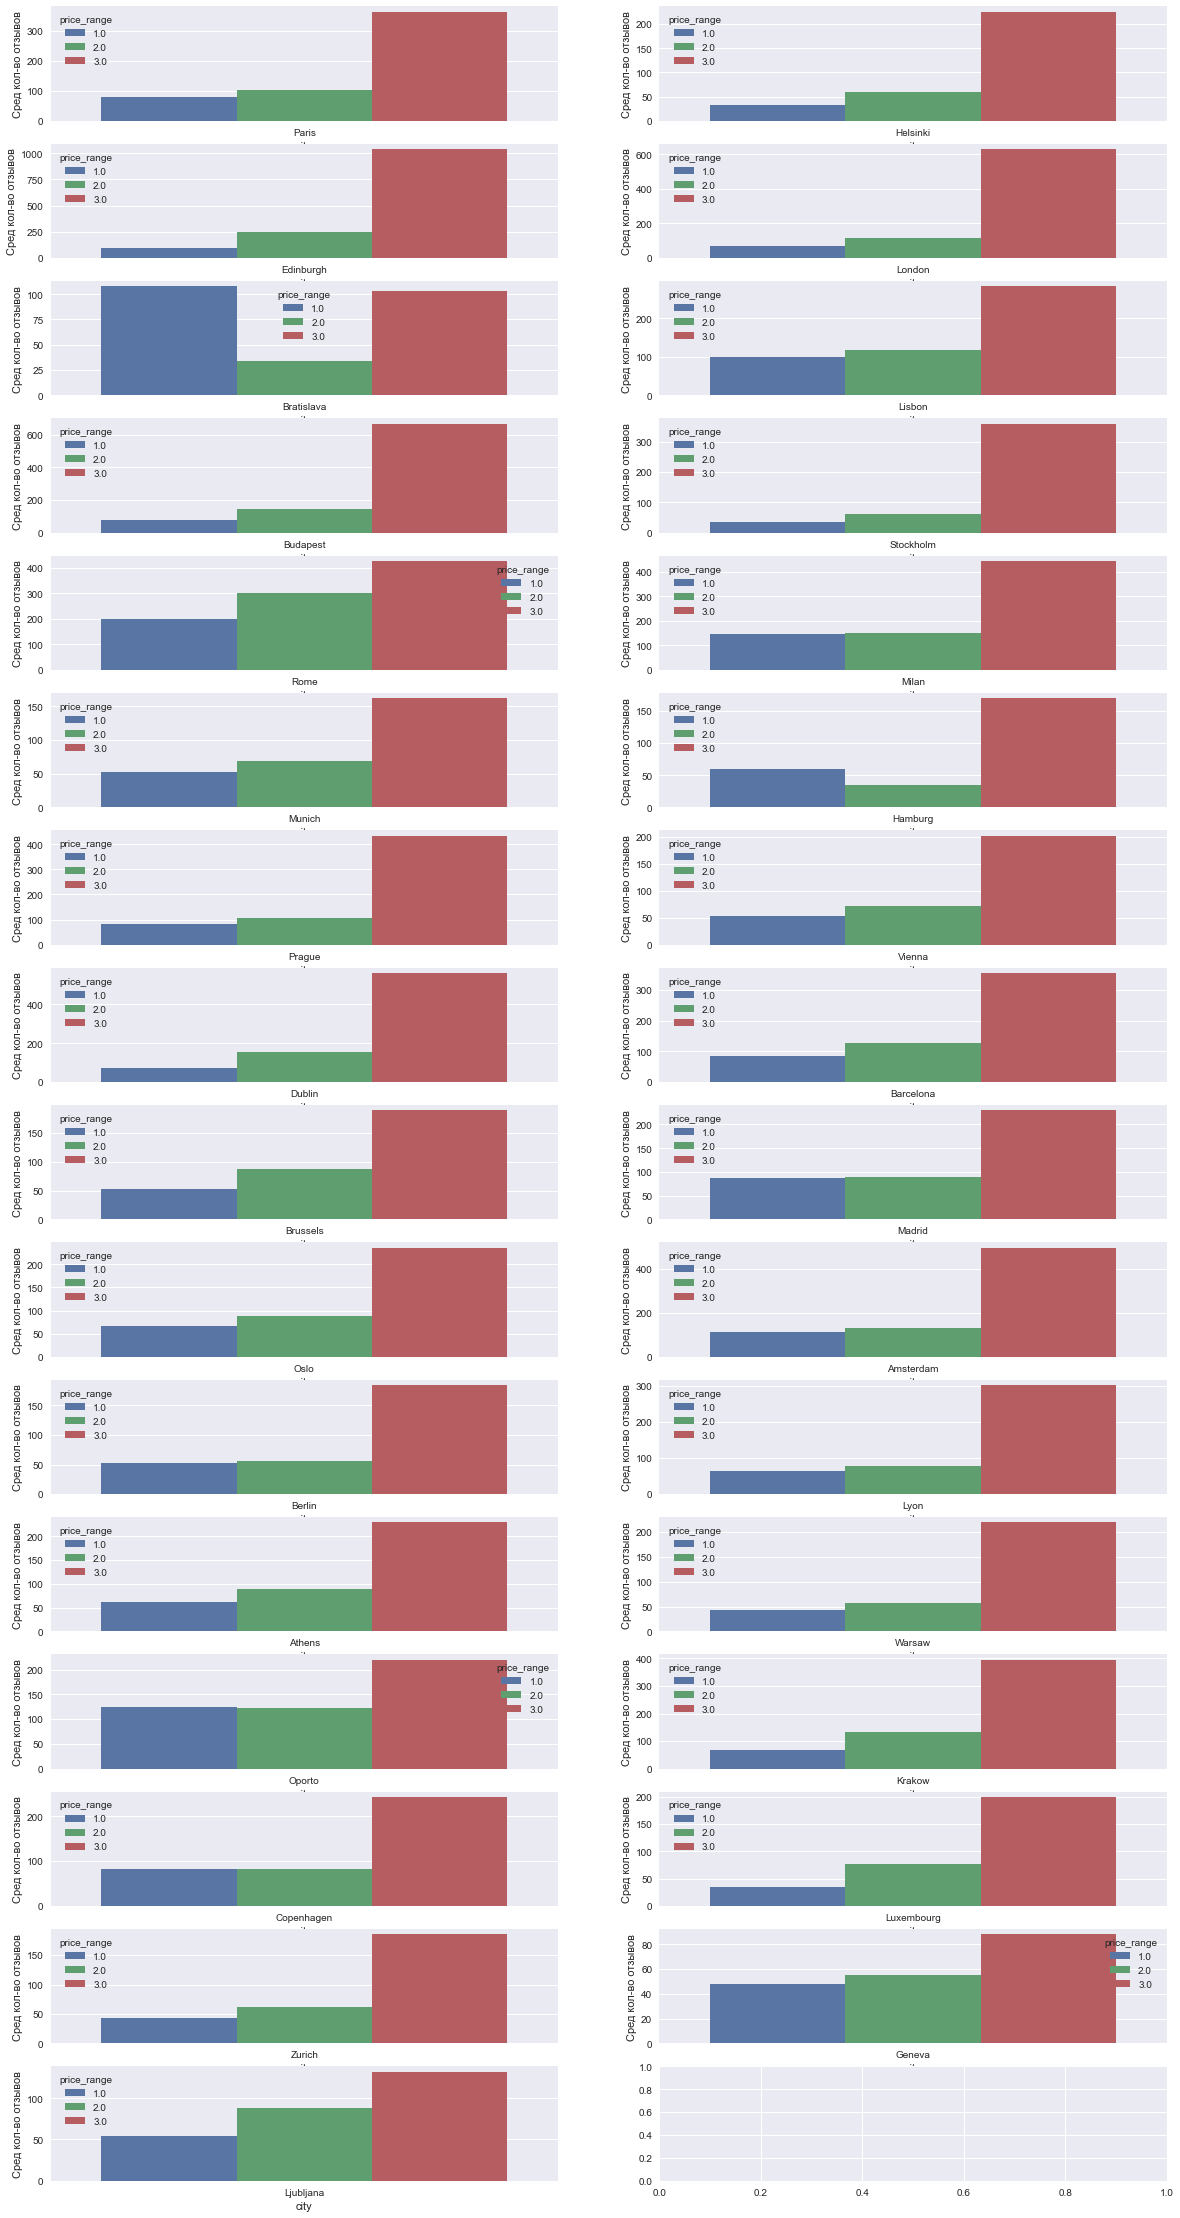

In [189]:
fig_price_ranges, ax_price_ranges = plt.subplots(16, 2, figsize=(20, 40))

ind = 1
for i in range(1, 17):
    for j in range(1, 3):
        if (ind <= len(cities)):
            city = cities[ind-1]
            ind += 1
            city_revs = pd.DataFrame(
                reviews_city_price.loc[(city), 'avg_reviews'])
            city_revs['city'] = city
            city_revs = city_revs.reset_index()
            fig_price_ranges.add_subplot(ax_price_ranges[i-1, j-1])
            sns.barplot(data=city_revs, x='city',
                        y='avg_reviews', hue='price_range')
            plt.ylabel('Сред кол-во отзывов')

В подавляющем большинстве городов самые обсуждаемые рестораны относятся к высокому ценовому диапазону: чем выше ожидаемое качество, тем выше внимание клиентов.

### 2.7 Количество отзывов

Text(0, 0.5, 'кол-во отзывов')

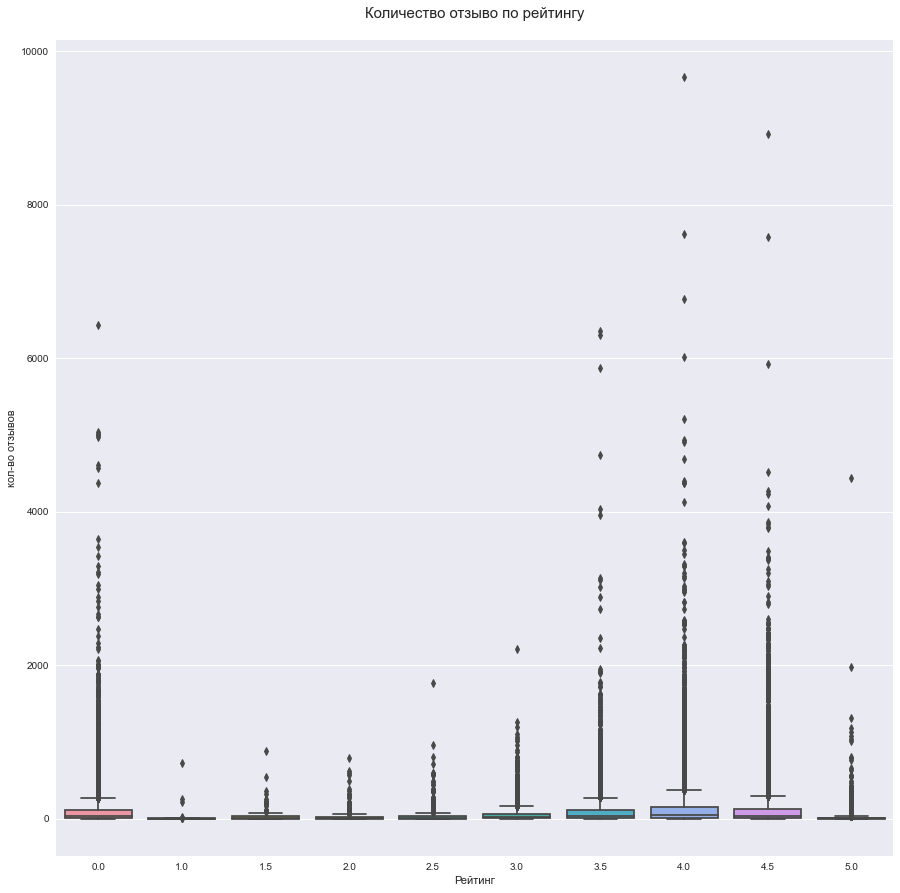

In [190]:
plt.figure(figsize=(15, 15))

sns.boxplot(x='rating', y='reviews_number', data=df)

plt.title('Количество отзыво по рейтингу\n', fontsize=15)
plt.xlabel('Рейтинг')
plt.ylabel('кол-во отзывов')

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: reviews_number, dtype: float64

<AxesSubplot:>

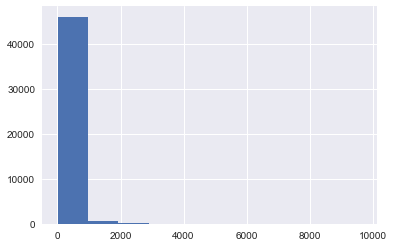

In [191]:
display(df.reviews_number.describe())
df.reviews_number.hist()

25-й перцентиль: 9.0, 75-й перцентиль: 115.0, IQR: 106.0,  Границы выбросов: [-150.0, 274.0].


<AxesSubplot:>

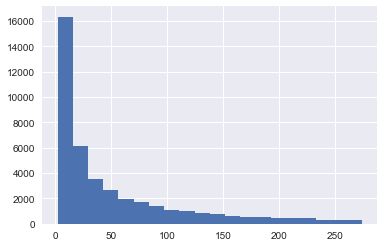

In [192]:
params = med_iqr(df.reviews_number)

df.loc[df.reviews_number.between(params['perc25'] - 1.5*params['iqr'], params['perc75']
                                 + 1.5*params['iqr'])]['reviews_number'].hist(bins=20)

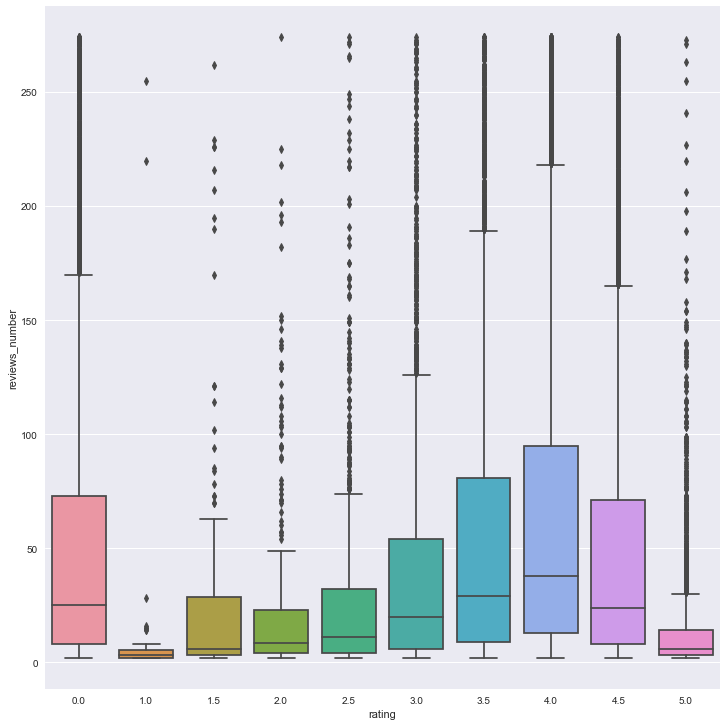

In [193]:
df.loc[((df.reviews_number < (params['perc25'] - 1.5*params['iqr']))
        | (df.reviews_number > (params['perc75'] + 1.5*params['iqr']))), 'reviews_number'] = None
sns.catplot(x="rating", y="reviews_number", kind="box", data=df, height=10)

Анализ данной переменной не дал явных результатов, но количестов отзывов явно будет влиять на оценку.  
Дальненйшие измененея будут проводится своместно с переменной "Отзывы".

### 2.8 Отзывы

Проведём дополнительный анализ данного столбца, так-как он будет одназначно влиять на рейтинг

In [194]:
print(df['reviews'][15])

[['Very nice food and staff', 'Lovely service and staff!'], ['01/01/2017', '11/12/2016']]


Имеются пустые значения - [ [ ],[ ] ].

Необходимо разделить значения объединнённые в один столбец в датасете, на 4 незавиимых.
Дата первого и последнего отзыва (так-же можно вывести количестов дней между ними)
Первый и последний отзыв.


In [ ]:
lrx = re.compile('\[\[.*\]\]')  # шаблон для поиска
nan = None
df = df.apply(review_extraction, axis=1)
df.sample(3)

Создадим столбец с разницей во времени между первым и последним обзорами

In [ ]:
df['diff_rev'] = df['last_date'] - df['first_date']
df['diff_rev'] = df['diff_rev'].apply(get_days)
df.sample(3)

Поверим результат

In [ ]:
sns.boxplot(x=df.diff_rev.values)

Некоторые даты не относятся к первому комментарию, потому мы имеем отрицательные значения. Исправим эти значения.

In [ ]:
df['diff_rev'] = df['diff_rev'].apply(lambda x: abs(x))

In [ ]:
sns.boxplot(df.diff_rev.values)

Рейтинг ресторана может зависеть не только от того, сколько времени прошло между двумя последними отзывами, но и от того, сколько дней прошло с момента публикации последнего отзыва до текущей даты.
Создадим соответствующий столбец

In [ ]:
df['days_from_last_rev'] = df['last_date'].apply(
    lambda date: CURRENT_DATE - date)
df['days_from_last_rev'] = df['days_from_last_rev'].apply(get_days)

In [ ]:
df.sample(3)

Проверим количество пустых значений для отзывово и для их количества.

In [ ]:
df[['first_review', 'last_review']].isnull().sum()

In [ ]:
df['reviews_number'].isnull().sum()

Подавляющее большинство отсутствующих отзывов относятся к отзывам, размещенным «первым».

Теперь давайте отсортируем наш набор данных и сравним отсутствующие отзывы с количеством отсутствующих отзывов.

In [ ]:
no_rev_num = df[df['reviews_number'].isnull()]
no_rev_num.sample(2)

In [ ]:
no_rev_num[['first_review', 'last_review']].isnull().sum()

Номер обзора не показывает явную взаимосвзяь с  количеством отзывов.В столбцах отзывов у есть хотя бы один отзыв, но он не засчитывается в количестве отзывов.

Для лучшей обработки данных в 'Feature engineering' создадим два новых столбца, которые укажут нам, в каком «обзоре» отсутствуют значения. И заменим пустые значения на'No comment' для дальнейшей обработки данных

In [ ]:
df['first_review_miss'] = df['first_review'].isnull().astype('uint8')
df['last_review_miss'] = df['last_review'].isnull().astype('uint8')
df['last_review'] = df['last_review'].fillna('no comment')
df['first_review'] = df['first_review'].fillna('no comment')
df.sample(2)

### 2.9 url_ta и id_ta


Данные колонки мало информативны, потому мы оставим их для последующего преобразования.
Единственное что сделаем это преобразуем id_ta и проверим на дубликаты.


In [ ]:
df['id_ta'] = df['id_ta'].apply(lambda x: int(x[1:]))

In [ ]:
df['id_ta'].value_counts()

# 3. Feature Engineering и дополнительная очистка данных

### 3.1 Идентификационный номер ресторана

Добавим дополнительную идентификацию сетевых ресторанов.
Сетевым ресторанам будем присваивать переменную 1, остальным 0.

In [ ]:
chained_rest_list = list(df['restaurant_id'].value_counts()[
    df['restaurant_id'].value_counts() > 1].index)

df['chained_rest'] = df[df['restaurant_id'].isin(
    chained_rest_list)].restaurant_id.apply(lambda x: 1)
df['chained_rest'] = df['chained_rest'].fillna(0)

# Проверка
df['chained_rest'].value_counts()

### 3.2 Город

Добавим столбец, который будет определять является ли город, в котором находится ресторан, столицей страны или нет.

In [ ]:
all_cities = df['city'].value_counts().index
all_cities

Так как городов не очень много, создадим отдельный словарь, который будет подтверждать принадлежность города.

In [ ]:
capital = [True, True, True, False, True, False, True,
           True, True, True, True, True, False, False,
           False, True, True, True, True, True, True,
           True, False, False, False, False, True,
           True, True, True, True]

capital_dict = dict(zip(list(all_cities), capital))

In [ ]:
df['capital'] = df['city'].map(capital_dict)

# проверяем
df.head(2)

Добавим количество людей проживаюших в этих городах.
А так-же пренадлежность города к стране.
ЗЫ В дальнейшем можно, добавить среднее количество туристов за год.

In [ ]:
city_population = {
    'London': 8908081,
    'Paris': 2148327,
    'Madrid': 3266126,
    'Barcelona': 1664182,
    'Berlin': 3644826,
    'Milan': 1378689,
    'Rome': 2870500,
    'Prague': 1301132,
    'Lisbon': 505526,  #
    'Vienna': 1900000,
    'Amsterdam': 872080,
    'Brussels': 144784,
    'Hamburg': 1840000,
    'Munich': 1558395,
    'Lyon': 506615,
    'Stockholm': 975904,
    'Budapest': 1752286,
    'Warsaw': 1720398,
    'Dublin': 1793579,
    'Copenhagen': 1330993,
    'Athens': 3090508,
    'Edinburgh': 476100,
    'Zurich': 402275,
    'Oporto': 237559,
    'Geneva': 196150,
    'Krakow': 779115,
    'Oslo': 697549,
    'Helsinki':  656229,
    'Bratislava': 563682,
    'Luxembourg': 626108,
    'Ljubljana': 295504
}

In [ ]:
city_country = {
    'London': 'United Kingdom',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugal',
    'Vienna': 'Austria',
    'Amsterdam': 'Netherlands',
    'Brussels': 'Belgium',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Hungary',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland',
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Schotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugal',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenija'
}

Добавим полученный данные в датафрейм

In [ ]:
df['city_population'] = df['city'].map(city_population)
df['country'] = df['city'].map(city_country)

Так как в датасете представленно большое количество городом в которых назодится не очень много ресторанов, их можно присвоить дополнительное значение. Это позволит разделить города с большим колличеством ресторанов и остальными. 

In [ ]:
df['new_city'] = df['city']
top_cities_list = df['new_city'].value_counts()[df['new_city'].value_counts()
                                                > np.percentile((df['new_city'].value_counts().values), 70)].index.tolist()

In [ ]:
cities_to_drop = list(set(all_cities)-set(top_cities_list))
df.loc[df['new_city'].isin(cities_to_drop), 'new_city'] = 'Other'

In [ ]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df['new_city'], order=df['new_city'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Распределение городов\n', fontsize=15)
plt.xlabel('Название города')
plt.ylabel('Рестораны')

print(f'Общее количество городов: {df.city.nunique()}')

In [ ]:
df.head(10)

Закодируем значения городов, и добавим их в виде столбцов с названиями городов.

In [ ]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_city = pd.DataFrame(OH_encoder.fit_transform(df[['new_city']]))
OH_city.columns = OH_encoder.get_feature_names(['new_city'])

# Тест
OH_city.head(2)

Тоже самое проделаем со странами.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()  # create an object
le.fit(df['country'])
df['country_CODE'] = le.transform(df['country'])

# проверка
df.head(2)

### 3.3 Кухня

Добавим новый столбец, который считает количество кухонь представленных в ресторане.

In [ ]:
df['cuisine_count'] = df['cuisine_style'].apply(lambda x: len(x))

# проверка
df.head(2)

Добавим столбец, который определяет наличие редкого вида кухни (ниже 50%), представленных в ресторане

In [ ]:
cuisine_rare_lst = df.explode('cuisine_style')['cuisine_style'].value_counts()[
    df.explode('cuisine_style')['cuisine_style'].value_counts() < 50].index.tolist()

In [ ]:
df['rare_cuisine'] = df['cuisine_style'].apply(get_cuisine_rare)
# проверка
df.head(2)

Оценим влияние принадлежность кухни к региону, откуда она родом?

In [ ]:
cuisine_region = {
    'France': ['French', 'Central European'],
    'Sweden': ['Swedish', 'Scandinavian'],
    'United Kingdom': ['British'],
    'Germany': ['German', 'Central European'],
    'Italy': ['Pizza', 'Italian'],
    'Slovakia': ['Eastern European'],
    'Austria': ['Austrian'],
    'Spain': ['Spanish'],
    'Ireland': ['Irish'],
    'Belgium': ['Belgian'],
    'Switzerland': ['Swiss'],
    'Poland': ['Polish', 'Ukrainian'],
    'Hungary': ['Hungarian'],
    'Denmark': ['Scandinavian'],
    'Netherlands': ['Dutch'],
    'Portugal': ['Portuguese'],
    'Czech': ['Czech'],
    'Norway': ['Norwegian', 'Scandinavian'],
    'Finland': ['Central European'],
    'Schotland': ['Scottish'],
    'Slovenija': ['Slovenian'],
    'Greece': ['Greek'],
    'Luxembourg': ['Central European']
}

Cоздадим столбец с идентификатором, местная ли кухня и посчитаем их.

In [ ]:
df['local_cuisine'] = df.apply(get_local_cuisine, axis=1)
df['local_cuisine'].value_counts()

В нашем наборе данных есть 16751 кухня, принадлежащая стране происхождения.

Первичный анализ показал большое количество отзывов на вегенскую или полезную еды.  
Добавим столбец который указывает есть в ресторане подобная еда. 

In [ ]:
df['vegan_free'] = df.apply(get_vegan, axis=1)
# Тест
df.sample(2)

### 3.4 Ранг ресторана

Опираясь на провёденный анализ, создадим столбец с эквивалентным ранжированием.

Создадим столбец с общим количеством ресторанов в одном городе.

In [ ]:
city_restaurant = dict(df['city'].value_counts())
df['restaurant_qty'] = df['city'].map(city_restaurant)

Создадим эквивалентный рейтинг, разделив рейтинг в наборе данных на количеству ресторанов в городе

In [ ]:
df['equiv_ranking'] = df['ranking']/df['restaurant_qty']

Проверим распределение эквивалентный рейтинг

In [ ]:
plt.figure(figsize=(15, 7))

for city in (df['city'].value_counts())[0:10].index:
    sns.distplot(df['equiv_ranking'][df['city'] == city],
                 kde=False, label=city)

plt.legend(prop={'size': 10})
plt.title('Equivalent ranking Distribution among cities\n', fontsize=15)
plt.xlabel('Equivalent ranking')
plt.ylabel('Quantity (frequency)')

Создим столбец со средним количеством поситителей для одного ресторана в городе.

In [ ]:
df['people_per_restaur'] = df['city_population']/df['restaurant_qty']
df.head(2)

Создадим столбец с эквивалентом рейтинга отзывов на количество отзывов.

In [ ]:
df['reviews_in_city'] = df['city'].apply(lambda x: df.groupby(
    ['city'])['reviews_number'].sum().sort_values(ascending=False)[x])

In [ ]:
df['equivalent_rank_reviews'] = df['ranking'] / df['reviews_in_city']

# Тест
df.sample(2)

### 3.5 Цены в ресторане

Создадим столбец со средней ценовой категорией ресторанов в городе

In [ ]:
price_in_city_dict = df.groupby('city')['price_range'].mean().to_dict()
df['price_in_city'] = df['city'].map(price_in_city_dict)

In [ ]:
df['price_in_city'].value_counts()

In [ ]:
df.sample(2)

## 3.6 Отзывы

### 3.6.1 Количество отзывов

Для начала заполним пропущенные значения. При анализе столбца с отзывами выяснилось, что некоторые отзывы не засчитались, можно предположить, что это своего рода ошибка.
Заполним пустые значения: если есть хотя-бы один отзыв, то заполняем значением - 1, в противном случаем - 0.

In [ ]:
df['reviews_number'] = df.apply(lambda row: 1 if np.isnan(row['reviews_number']) and (
    row['last_review_miss'] == 0 or row['first_review_miss'] == 0) else row['reviews_number'], axis=1)

Пустые значения заполнены, проверим сколько осталось пустых значений и заполним их 0

In [ ]:
np.isnan(df['reviews_number']).sum()

In [ ]:
df['reviews_number'] = df['reviews_number'].fillna(0)

### 3.6.2 Количество дней между отзывами

Для более подробного анализу уже был создан столбец с количеством дней между отзывами, заполним пустые значения нулями.

In [ ]:
df['diff_rev'] = df['diff_rev'].fillna(0)
df['days_from_last_rev'] = df['days_from_last_rev'].fillna(0)

### 3.7 Итог

In [ ]:
correlation = df.corr()
display(correlation)
plt.subplots(figsize=(15, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

# 4. Подготовим данные для загрузки в модель

1 Уберём нечисловые столбцы.

In [ ]:
cols_to_drop = ['restaurant_id', 'city', 'new_city', 'cuisine_style',
                'url_ta', 'reviews', 'first_review',
                'last_review', 'first_date', 'last_date', 'country']

In [ ]:
df_to_model = df.drop(cols_to_drop, axis=1)

2 Объединим дополнительные датафреймы, полученные при анализе и предобработке.

In [ ]:
df_to_model = pd.concat([df_to_model, OH_city], axis=1)

In [ ]:
df_to_model.head(5)

In [ ]:
X = df_to_model.corr()

# Chek the determinant of matrix X (via eginvalues)
evals, evec = np.linalg.eig(X)
ev_product = np.prod(evals)  # product of evalues same as determinant


fig, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(X, vmax=.7, square=True, annot=True)
print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
print(f'Determinat of matrix :{ev_product}')
print(f'Shape of matrix :{np.shape(X)}')

In [ ]:
# Теперь выделим тестовую часть
train_data = df_to_model.query('sample == 1').drop(['sample'], axis=1)
test_data = df_to_model.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values               # наш таргет
X = train_data.drop(['rating'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# тест
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# 5. Модель

In [ ]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

Реальные рейтинги всегда кратны 0,5, используем функцию для округления прогнозируемых оценок.

In [ ]:
for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# 1st approx. MAE: 0.16425
# 2nd approx. MAE: 0.1639375 - changed analysis to polarity
# 3nd approx. MAE: 0.163 - dropped useless cols

In [ ]:
# Выделим самые важные признаки
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Определим какие столбцы меньше всего влияют на модель

In [ ]:
# To identify what cols are not impact on a result
a = list(feat_importances.sort_values(
    ascending=False).head(15).reset_index()['index'])
b = set(df_to_model.columns)
cols_to_drop = list(b-set(a))
cols_to_drop

# 6. SUBMISSION

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
# Окргулим значения
for i in range(len(predict_submission)):
    predict_submission[i] = round_rating_pred(predict_submission[i])

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)